# Import

In [26]:
import numpy as np
import os
import time
import math
import pickle
import argparse
import random
from random import shuffle
from tqdm import tqdm_notebook as tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
from advertorch.attacks import GradientSignAttack
from torch.nn.utils import weight_norm

In [27]:
import sys
sys.path.append("../src/")

from datasetManager import DatasetManager
from generators import Generator, CoTrainingGenerator
from samplers import CoTrainingSampler
import signal_augmentations as sa 

from models import cnn
from losses import loss_cot, loss_diff, loss_diff, p_loss_diff, p_loss_sup
from metrics import CategoricalAccuracy, Ratio
from ramps import Warmup, sigmoid_rampup

# Utils

## Arguments

In [29]:
class Args:
    def __init__(self):
        self.sess = "default"
        self.nb_view = 2
        self.batchsize = 100
        self.lambda_cot_max = 10
        self.lambda_diff_max = 0.5
        self.ratio = 0.1
        self.seed = 1234
        self.epochs = 600
        self.warm_up = 80
        self.momentum = 0.0
        self.decay = 1e-3
        self.epsilon = 0.02
        self.num_class = 10
        self.cifar10_dir = "/corpus/corpus/UrbanSound8K"
        self.tensorboard_dir = "tensoboard_cotraining"
        self.checkpoint_dir = "checkpoint"
        self.base_lr = 0.05
        self.resume = False
        self.job_name = "default"
        self.multi_gpu = False
args = Args()

## Reproducibility

In [30]:
def reset_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark = False
reset_seed(args.seed)

In [31]:
import datetime

def get_datetime():
    now = datetime.datetime.now()
    return str(now)[:10] + "_" + str(now)[11:-7]

# Prep Co-Training

## dataset

In [23]:
# load the data
audio_root = "../dataset/audio"
metadata_root = "../dataset/metadata"
dataset = DatasetManager(metadata_root, audio_root, verbose=2)

# prepare the sampler with the specified number of supervised file
nb_train_file = len(dataset.audio["train"])
nb_s_file = int(nb_train_file * args.ratio)
nb_s_file = nb_s_file - (nb_s_file % DatasetManager.NB_CLASS)  # need to be a multiple of number of class
nb_u_file = nb_train_file - nb_s_file


sampler = CoTrainingSampler(args.batchsize, nb_s_file, nb_u_file, nb_view=args.nb_view, ratio=None, method="duplicate") # ratio is manually set here
train_dataset = CoTrainingGenerator(dataset, sampler)

## Models

In [24]:
model_func = cnn

m1, m2 = model_func(), model_func()

m1 = m1.cuda()
m2 = m2.cuda()

## Loaders & adversarial generators

In [25]:

x, y = train_dataset.validation
x = torch.from_numpy(x)
y = torch.from_numpy(y)
val_dataset = torch.utils.data.TensorDataset(x, y)

train_loader = data.DataLoader(train_dataset, batch_sampler=sampler, num_workers=4)
val_loader = data.DataLoader(val_dataset, batch_size=128, num_workers=4)

# adversarial generation
adv_generator_1 = GradientSignAttack(
    m1, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-math.inf, clip_max=math.inf, targeted=False
)

adv_generator_2 = GradientSignAttack(
    m2, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-math.inf, clip_max=math.inf, targeted=False
)

## optimizers & callbacks 

In [26]:
params = list(m1.parameters()) + list(m2.parameters())
optimizer = optim.SGD(params, lr=args.base_lr, momentum=args.momentum, weight_decay=args.decay)

lr_lambda = lambda epoch: (1.0 + math.cos((epoch-1)*math.pi/args.epochs))
lr_scheduler = LambdaLR(optimizer, lr_lambda)

callbacks = [lr_scheduler]

## Metrics and hyperparameters

In [27]:
# define the metrics
ratioS = [Ratio(), Ratio()]
ratioU = [Ratio(), Ratio()]
ratioSU = [Ratio(), Ratio()]
accS = [CategoricalAccuracy(), CategoricalAccuracy()]
accU = [CategoricalAccuracy(), CategoricalAccuracy()]
accSU = [CategoricalAccuracy(), CategoricalAccuracy()]

# define the warmups
lambda_cot = Warmup(args.lambda_cot_max, args.warm_up, sigmoid_rampup)
lambda_diff = Warmup(args.lambda_diff_max, args.warm_up, sigmoid_rampup)

def reset_all_metrics():
    all_metrics = [*ratioS, *ratioU, *ratioSU, *accS, *accU, *accSU]
    for m in all_metrics:
        m.reset()
        
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

title = "%s_%s_%slcm_%sldm_%swl" % (
    get_datetime(),
    args.job_name,
    args.lambda_cot_max,
    args.lambda_diff_max,
    args.warm_up,
)
tensorboard = SummaryWriter("%s/%s" % (args.tensorboard_dir, title))

# Training

In [28]:
def train(epoch):
    m1.train()
    m2.train()

    running_loss = 0.0
    ls = 0.0
    lc = 0.0 
    ld = 0.0
    
    start_time = time.time()
    print("")
    
    for batch, (X, y) in enumerate(train_loader):
        X = [x.squeeze() for x in X]
        y = [y_.squeeze() for y_ in y]
    
        # separate Supervised (S) and Unsupervised (U) parts
        X_S, X_U = X[:-1], X[-1]
        y_S, y_U = y[:-1], y[-1]
        
        for i in range(len(X_S)):
            X_S[i] = X_S[i].cuda()
            y_S[i] = y_S[i].cuda()
        X_U, y_U = X_U.cuda(), y_U.cuda()

        logits_S1 = m1(X_S[0])
        logits_S2 = m2(X_S[1])
        logits_U1 = m1(X_U)
        logits_U2 = m2(X_U)

        _, pred_S1 = torch.max(logits_S1, 1)
        _, pred_S2 = torch.max(logits_S2, 1)

        # pseudo labels of U 
        _, pred_U1 = torch.max(logits_U1, 1)
        _, pred_U2 = torch.max(logits_U2, 1)

        # ======== Generate adversarial examples ========
        # fix batchnorm ----
        m1.eval()
        m2.eval()

        #generate adversarial examples ----
        adv_data_S1 = adv_generator_1.perturb(X_S[0], y_S[0])
        adv_data_U1 = adv_generator_1.perturb(X_U, pred_U1)

        adv_data_S2 = adv_generator_2.perturb(X_S[1], y_S[1])
        adv_data_U2 = adv_generator_2.perturb(X_U, pred_U2)

        m1.train()
        m2.train()

        # predict adversarial examples ----
        adv_logits_S1 = m1(adv_data_S2)
        adv_logits_S2 = m2(adv_data_S1)

        adv_logits_U1 = m1(adv_data_U2)
        adv_logits_U2 = m2(adv_data_U1)

        # ======== calculate the differents loss ========
        # zero the parameter gradients ----
        optimizer.zero_grad()
        m1.zero_grad()
        m2.zero_grad()

        # losses ----
        Loss_sup_S1, Loss_sup_S2, Loss_sup = p_loss_sup(logits_S1, logits_S2, y_S[0], y_S[1])
        Loss_cot = loss_cot(logits_U1, logits_U2)
        pld_S, pld_U, Loss_diff = p_loss_diff(logits_S1, logits_S2, adv_logits_S1, adv_logits_S2, logits_U1, logits_U2, adv_logits_U1, adv_logits_U2)
        
        total_loss = Loss_sup + lambda_cot.next() * Loss_cot + lambda_diff.next() * Loss_diff
        total_loss.backward()
        optimizer.step()

        # ======== Calc the metrics ========
        # accuracies ----
        pred_SU1 = torch.cat((pred_S1, pred_U1), 0)
        pred_SU2 = torch.cat((pred_S2, pred_U2), 0)
        y_SU1 = torch.cat((y_S[0], y_U), 0)
        y_SU2 = torch.cat((y_S[1], y_U), 0)

        acc_S1 = accS[0](pred_S1, y_S[0])
        acc_S2 = accS[1](pred_S2, y_S[1])
        acc_U1 = accU[0](pred_U1, y_U)
        acc_U2 = accU[1](pred_U2, y_U)
        acc_SU1 = accSU[0](pred_SU1, y_SU1)
        acc_SU2 = accSU[1](pred_SU2, y_SU2)
        
        # ratios  ----
        _, adv_pred_S1 = torch.max(adv_logits_S1, 1)
        _, adv_pred_S2 = torch.max(adv_logits_S2, 1)
        _, adv_pred_U1 = torch.max(adv_logits_U1, 1)
        _, adv_pred_U2 = torch.max(adv_logits_U2, 1)

        adv_pred_SU1 = torch.cat((adv_pred_S1, adv_pred_U1), 0)
        adv_pred_SU2 = torch.cat((adv_pred_S2, adv_pred_U2), 0)
        adv_y_SU1 = torch.cat((y_S[0], pred_U1), 0)
        adv_y_SU2 = torch.cat((y_S[1], pred_U2), 0)

        ratio_S1 = ratioS[0](adv_pred_S1, y_S[0])
        ratio_S2 = ratioS[1](adv_pred_S2, y_S[1])
        ratio_U1 = ratioU[0](adv_pred_U1, pred_U1)
        ratio_U2 = ratioU[1](adv_pred_U2, pred_U2)
        ratio_SU1 = ratioSU[0](adv_pred_SU1, adv_y_SU1)
        ratio_SU2 = ratioSU[1](adv_pred_SU2, adv_y_SU2)
        # ========
        
        running_loss += total_loss.item()
        ls += Loss_sup.item()
        lc += Loss_cot.item()
        ld += Loss_diff.item()
        
        # print statistics
        print("Epoch %s: %.2f%% : train acc: %.3f %.3f - Loss: %.3f %.3f %.3f %.3f - time: %.2f" % (
            epoch, (batch / len(sampler)) * 100,
            acc_SU1, acc_SU2,
            running_loss/(batch+1), ls/(batch+1), lc/(batch+1), ld/(batch+1),
            time.time() - start_time,
        ), end="\r")

    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', total_loss.item(), epoch)
    tensorboard.add_scalar('train/Lsup', Loss_sup.item(), epoch )
    tensorboard.add_scalar('train/Lcot', Loss_cot.item(), epoch )
    tensorboard.add_scalar('train/Ldiff', Loss_diff.item(), epoch )
    tensorboard.add_scalar("train/acc_1", acc_SU1, epoch )
    tensorboard.add_scalar("train/acc_2", acc_SU2, epoch )

    tensorboard.add_scalar("detail_loss/Lsus S1", Loss_sup_S1.item(), epoch)
    tensorboard.add_scalar("detail_loss/Lsus S2", Loss_sup_S2.item(), epoch)
    tensorboard.add_scalar("detail_loss/Ldiff S", pld_S.item(), epoch)
    tensorboard.add_scalar("detail_loss/Ldiff U", pld_U.item(), epoch)

    tensorboard.add_scalar("detail_acc/acc S1", acc_S1, epoch)
    tensorboard.add_scalar("detail_acc/acc S2", acc_S2, epoch)
    tensorboard.add_scalar("detail_acc/acc U1", acc_U1, epoch)
    tensorboard.add_scalar("detail_acc/acc U2", acc_U2, epoch)

    tensorboard.add_scalar("detail_ratio/ratio S1", ratio_S1, epoch)
    tensorboard.add_scalar("detail_ratio/ratio S2", ratio_S2, epoch)
    tensorboard.add_scalar("detail_ratio/ratio U1", ratio_U1, epoch)
    tensorboard.add_scalar("detail_ratio/ratio U2", ratio_U2, epoch)
    tensorboard.add_scalar("detail_ratio/ratio SU1", ratio_SU1, epoch)
    tensorboard.add_scalar("detail_ratio/ratio SU2", ratio_SU2, epoch)
    
    # Return the total loss to check for NaN
    return total_loss.item()

In [29]:
def test(epoch):
    global best_acc
    m1.eval()
    m2.eval()
    correct1 = 0
    correct2 = 0
    total1 = 0
    total2 = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs = inputs.cuda()
            targets = targets.cuda()

            outputs1 = m1(inputs)
            predicted1 = outputs1.max(1)
            total1 += targets.size(0)
            correct1 += predicted1[1].eq(targets).sum().item()

            outputs2 = m2(inputs)
            predicted2 = outputs2.max(1)
            total2 += targets.size(0)
            correct2 += predicted2[1].eq(targets).sum().item()

    print('\nnet1 test acc: %.3f%% (%d/%d) | net2 test acc: %.3f%% (%d/%d)'
        % (100.*correct1/total1, correct1, total1, 100.*correct2/total2, correct2, total2))
    
    tensorboard.add_scalar("val/acc 1", correct1 / total1, epoch)
    tensorboard.add_scalar("val/acc 2", correct2 / total2, epoch)
    
    tensorboard.add_scalar("detail_hyperparameters/lambda_cot", lambda_cot(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/lambda_diff", lambda_diff(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/learning_rate", get_lr(optimizer), epoch)

    # Apply callbacks
    for c in callbacks:
        c.step()


In [ ]:
for epoch in range(0, args.epochs):
    total_loss = train(epoch)
    if np.isnan(total_loss):
        print("Losses are NaN, stoping the training here")
        break
    test(epoch)

# tensorboard.export_scalars_to_json('./' + args.tensorboard_dir + 'output.json')
# tensorboard.close()


# Prep Supervised training (same ratio)

## dataset

In [32]:
# load the data
audio_root = "../dataset/audio"
metadata_root = "../dataset/metadata"
dataset = DatasetManager(metadata_root, audio_root, verbose=2)

# prepare the sampler with the specified number of supervised file
nb_train_file = len(dataset.audio["train"])
nb_s_file = int(nb_train_file * args.ratio)
nb_s_file = nb_s_file - (nb_s_file % DatasetManager.NB_CLASS)  # need to be a multiple of number of class
nb_u_file = 0


sampler = CoTrainingSampler(args.batchsize, nb_s_file, nb_u_file, nb_view=args.nb_view, ratio=None, method="duplicate") # ratio is manually set here
train_dataset = CoTrainingGenerator(dataset, sampler)

## Model

In [33]:
model_func = cnn

m1 = model_func()

m1 = m1.cuda()

## Loaders & adversarial generators

In [35]:
x, y = train_dataset.validation
x = torch.from_numpy(x)
y = torch.from_numpy(y)
val_dataset = torch.utils.data.TensorDataset(x, y)

train_loader = data.DataLoader(train_dataset, batch_sampler=sampler, num_workers=4)
val_loader = data.DataLoader(val_dataset, batch_size=128, num_workers=4)

# adversarial generation
adv_generator_1 = GradientSignAttack(
    m1, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-math.inf, clip_max=math.inf, targeted=False
)


## optimizers & callbacks & criterion

In [40]:
params = m1.parameters()
args.base_lr = 0.01
optimizer = optim.SGD(params, lr=args.base_lr, momentum=args.momentum, weight_decay=args.decay)

lr_lambda = lambda epoch: (1.0 + math.cos((epoch-1)*math.pi/args.epochs))
lr_scheduler = LambdaLR(optimizer, lr_lambda)

criterion = nn.CrossEntropyLoss()

callbacks = [lr_scheduler]

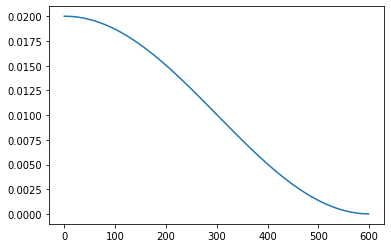

In [42]:
lr_lambda = lambda epoch: (1.0 + math.cos((epoch-1)*math.pi/args.epochs))

x = np.arange(600)

import matplotlib.pyplot as plt
plt.plot([args.base_lr * lr_lambda(i) for i in x])
plt.show()

## Metrics and hyperparameters

In [43]:
# define the metrics
acc_func = CategoricalAccuracy()

def reset_all_metrics():
    acc_func.reset()
        
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

title = "%s_supervised" % (get_datetime())
tensorboard = SummaryWriter("%s/%s" % (args.tensorboard_dir, title))

# Training

In [44]:
def train(epoch):
    m1.train()

    running_loss = 0.0
    
    start_time = time.time()
    print("")
    
    for batch, (X, y) in enumerate(train_loader):
        X = [x.squeeze() for x in X]
        y = [y_.squeeze() for y_ in y]
    
        # separate Supervised (S) and Unsupervised (U) parts
        X_S, X_U = X[:-1], X[-1]
        y_S, y_U = y[:-1], y[-1]
        
        # Only one view interesting, no U
        X_S = X_S[0]
        y_S = y_S[0]
        
        X_S, y_S = X_S.cuda(), y_S.cuda()

        # ======== perform prediction ========
        logits_S = m1(X_S)
        _, pred_S = torch.max(logits_S, 1)


        # ======== calculate loss ========
        loss_sup = criterion(logits_S, y_S)
        total_loss = loss_sup
        
        # ======== backpropagation =======
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # ======== Calc the metrics ========
        acc = acc_func(pred_S, y_S)
        running_loss += total_loss.item()
        
        # print statistics
        print("Epoch %s: %.2f%% : train acc: %.3f - Loss: %.3f - time: %.2f" % (
            epoch, (batch / len(sampler)) * 100,
            acc,
            running_loss / (batch+1),
            time.time() - start_time,
        ), end="\r")

    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', total_loss.item(), epoch)
    tensorboard.add_scalar('train/acc', acc, epoch)
    
    # Return the total loss to check for NaN
    return total_loss.item()

In [45]:
def test(epoch):
    m1.eval()
    
    reset_all_metrics()
    
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(val_loader):
            X_S = X.cuda()
            y_S = y.cuda()

            logits_S = m1(X_S)
            _, pred_S = torch.max(logits_S, 1)
            
            loss_val = criterion(logits_S, y_S)
            
            acc_val = acc_func(pred_S, y_S)
        
        print("\nEpoch %s: Val acc: %.3f - loss: %.3f" % (
            epoch,
            acc_val,
            loss_val.item()
        ))
    
    tensorboard.add_scalar("val/acc", acc_val, epoch)
    tensorboard.add_scalar("val/loss", loss_val.item(), epoch)
    
    tensorboard.add_scalar("detail_hyperparameters/learning_rate", get_lr(optimizer), epoch)

    # Apply callbacks
    for c in callbacks:
        c.step()


In [ ]:
for epoch in range(0, args.epochs):
    total_loss = train(epoch)
    
    if np.isnan(total_loss):
        print("Losses are NaN, stoping the training here")
        break
        
    test(epoch)


Epoch 0: 71.43% : train acc: 0.147 - Loss: 2.273 - time: 3.14
Epoch 0: Val acc: 0.095 - loss: 2.288

Epoch 1: 71.43% : train acc: 0.196 - Loss: 2.180 - time: 2.65
Epoch 1: Val acc: 0.137 - loss: 2.261

Epoch 2: 71.43% : train acc: 0.233 - Loss: 2.075 - time: 2.79
Epoch 2: Val acc: 0.165 - loss: 2.226

Epoch 3: 71.43% : train acc: 0.272 - Loss: 1.970 - time: 2.89
Epoch 3: Val acc: 0.197 - loss: 2.175

Epoch 4: 71.43% : train acc: 0.298 - Loss: 1.849 - time: 2.81
Epoch 4: Val acc: 0.214 - loss: 2.117

Epoch 5: 71.43% : train acc: 0.320 - Loss: 1.746 - time: 2.82
Epoch 5: Val acc: 0.248 - loss: 2.050

Epoch 6: 71.43% : train acc: 0.346 - Loss: 1.622 - time: 2.83
Epoch 6: Val acc: 0.238 - loss: 1.997

Epoch 7: 71.43% : train acc: 0.348 - Loss: 1.496 - time: 2.75
Epoch 7: Val acc: 0.233 - loss: 1.956

Epoch 8: 71.43% : train acc: 0.365 - Loss: 1.390 - time: 2.66
Epoch 8: Val acc: 0.242 - loss: 1.923

Epoch 9: 71.43% : train acc: 0.384 - Loss: 1.299 - time: 2.82
Epoch 9: Val acc: 0.319 - lo

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪

# Statistic on inputs

In [1]:
from scipy.stats import kurtosis

for batch, (X, y) in enumerate(train_loader):
        X = [x.squeeze() for x in X]
        y = [y_.squeeze() for y_ in y]
    
        # separate Supervised (S) and Unsupervised (U) parts
        X_S, X_U = X[:-1], X[-1]
        y_S, y_U = y[:-1], y[-1]
        
        X_U = X_U.numpy()
        print(X_U.shape)
        
        # max
        val = X_U.max(axis=(1, 2))
        print("max max: ", val.max())
        print("min max: ", val.min())
        print("mean max: ", val.mean())
        print("std max: ", val.std())
        print("kurosis: ", kurtosis(val))
        
        # min
        print("------------------")
        val = X_U.min(axis=(1, 2))
        print("max max: ", val.max())
        print("min max: ", val.min())
        print("mean max: ", val.mean())
        print("std max: ", val.std())
        print("kurosis: ", kurtosis(val))
        
        # mean
        print("------------------")
        val = X_U.mean(axis=(1, 2))
        print("max max: ", val.max())
        print("min max: ", val.min())
        print("mean max: ", val.mean())
        print("std max: ", val.std())
        print("kurosis: ", kurtosis(val))
        
        # std
        print("------------------")
        val = X_U.std(axis=(1, 2))
        print("max max: ", val.max())
        print("min max: ", val.min())
        print("mean max: ", val.mean())
        print("std max: ", val.std())
        print("kurosis: ", kurtosis(val))
        
        break

NameError: name 'train_loader' is not defined